### **IMPORTING LIBRARIES**


In [2]:
from google.colab import drive
drive.mount('/content/drive')
import warnings
warnings.filterwarnings("ignore")
import torch
import torch.nn as nn
from sklearn import metrics
import torchvision
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets,transforms,models
import torchvision.transforms as transforms
from mlxtend.plotting import plot_decision_regions
from sklearn.decomposition import PCA
from torch.autograd import Variable
from PIL import Image
from __future__ import print_function,division
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
from torch import optim
import time
import os
import copy
import matplotlib.pyplot as plt
cudnn.benchmark=True
plt.ion()


Mounted at /content/drive


In [3]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### **Loading model,train image features,labels ( previously saved in Feature_Extraction.ipynb)**
 

In [4]:
model=torch.load('/content/drive/MyDrive/assignment1_data/classification_dataset/model')
train_df=np.load('/content/drive/MyDrive/train_df.npy')
train_labels=np.load('/content/drive/MyDrive/train_labels.npy')

In [5]:
#importing feature extractor libraries
from torchvision.models.feature_extraction import get_graph_node_names, create_feature_extractor
nodes=get_graph_node_names(model)

### **Data Noramlization**

In [6]:
#data preprocessing
data_transforms={'train':transforms.Compose([transforms.RandomResizedCrop(224)
,transforms.RandomHorizontalFlip(),transforms.ToTensor(),transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])]),
'test':transforms.Compose([transforms.Resize(256)
,transforms.CenterCrop(224),transforms.ToTensor(),transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])
}

### **Loading Data using DataLoader**

In [7]:
#loading data into data_dir
data_dir = '/content/drive/MyDrive/FT_1/assignment1_data/classification_dataset/'

image_datasets={x: datasets.ImageFolder(os.path.join(data_dir,x),data_transforms[x]) for x in ['train','test']}

#loading entire test set in single batch i.e, batch of 120
dataloaders_test={x: torch.utils.data.DataLoader(image_datasets[x], batch_size=120,shuffle=True,num_workers=4) for x in ['test']}

test_data_size=len(image_datasets['test'])

class_names=image_datasets['train'].classes

### **Extracting features for Last FC layer for test Images**

In [8]:
#extracting features from last fully connected layer
with torch.no_grad():
  return_nodes={'flatten':'l5'}
  model_FE=create_feature_extractor(model,return_nodes=return_nodes)
  model_FE.eval()
  test_inputs_all,test_classes_all=next(iter(dataloaders_test['test']))
  test_inputs_all=test_inputs_all.to(device)
  features=model_FE(test_inputs_all)

In [9]:
#confirming 120 test images with each 512 dimensional vector
for layer_name,layer_feature in features.items():
  print("Test_data_features_shape:",end=' ')
  print(layer_feature.shape)
  test_data_features_one=layer_feature


Test_data_features_shape: torch.Size([120, 512])


### **Implementing KNN**

In [10]:
#importing knn classifier from sklearn 
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 5)
for i in range(len(train_df)):
  train_df[i].reshape(1,-1)
knn.fit(train_df,train_labels)

KNeighborsClassifier()

### **Classification using KNN**

In [11]:
#Implementing knn 
counter=0
y_true=[]
y_prediction=[]
for i in range(test_data_size):
  test_df= test_data_features_one[i].detach().cpu().numpy()
  test_class=test_classes_all[i]
  y_pred=knn.predict(test_df.reshape(1,-1))
  y_prediction.append(class_names[y_pred[0]])
  y_true.append(class_names[test_classes_all[i].detach().cpu().numpy()])
  if(y_pred==test_classes_all[i].detach().cpu().numpy()):
    counter=counter+1
print("Test Accuracy:")
print(counter/test_data_size)
print("----------------------------")
print("Classification Report:")
report=metrics.classification_report(y_true, y_prediction)    #classification report
print(report)
print("----------------------------")
print("Confusion Matrix:")
cf_matrix=metrics.confusion_matrix(y_true, y_prediction)      #confusion matrix
print(cf_matrix)


Test Accuracy:
0.95
----------------------------
Classification Report:
              precision    recall  f1-score   support

        bear       0.95      1.00      0.98        20
   butterfly       1.00      1.00      1.00        20
       camel       1.00      0.90      0.95        20
       chimp       1.00      1.00      1.00        20
        duck       1.00      0.80      0.89        20
    elephant       0.80      1.00      0.89        20

    accuracy                           0.95       120
   macro avg       0.96      0.95      0.95       120
weighted avg       0.96      0.95      0.95       120

----------------------------
Confusion Matrix:
[[20  0  0  0  0  0]
 [ 0 20  0  0  0  0]
 [ 0  0 18  0  0  2]
 [ 0  0  0 20  0  0]
 [ 1  0  0  0 16  3]
 [ 0  0  0  0  0 20]]


### **IMPLEMENTING PCA TO REDUCE FEATURE DIMENSIONS AND PLOTTING DECISION BOUNDARIES**

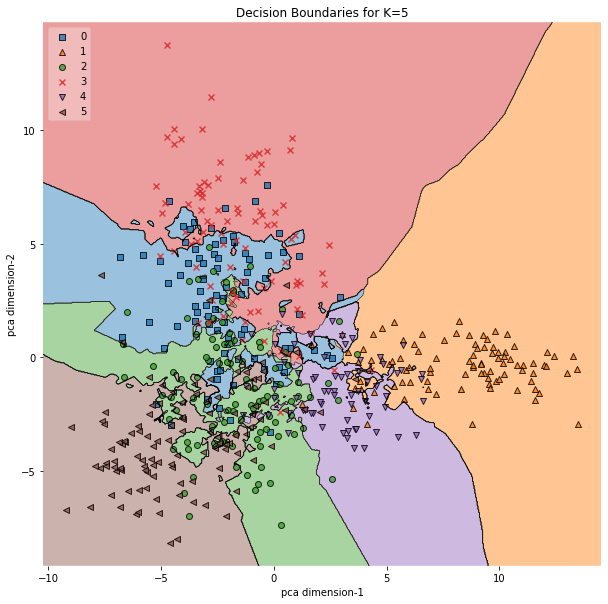

In [12]:
#Taking top 2 features using PCA , since for plotting decision boundaries we can't have more then 2 features
two_featured_pca = PCA(n_components = 2)
low_dimensioned_data = two_featured_pca.fit_transform(train_df)

knn_pca = KNeighborsClassifier(n_neighbors = 5,metric='euclidean')
knn_pca.fit(low_dimensioned_data, train_labels) #fitting KNN for 2 -dimnesional data

fig = plt.figure(figsize=(10,10))
plot_decision_regions(low_dimensioned_data, train_labels, clf = knn_pca, legend=2)  #plotting decision boundaries
plt.title('Decision Boundaries for K=5')
plt.xlabel('pca dimension-1')
plt.ylabel('pca dimension-2')
plt.show()